## Tapping Playground

This notebooks investigates optimal hand- and fingertapping algorithms as part of the 
ReTune-Dyskinesia project.



### 0. Loading packages and functions, defining paths



In [1003]:
# Importing Python and external packages
import os
import sys
import importlib
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

import seaborn as sns
from scipy import signal
from scipy import stats
from array import array
import datetime as dt
import h5py
from dataclasses import  dataclass, field
from itertools import compress
from typing import Any

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
codepath = os.path.join(projectpath, 'code')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')
rawdatapath = '/Users/jeroenhabets/OneDrive - Charité - Universitätsmedizin Berlin/BIDS_Berlin_ECOG_LFP/rawdata'
proc_data_path = os.path.join(projectpath, 'data/preprocess')
# change working directory to project-code folder
os.chdir(projectpath)
temp_save = os.path.join(projectpath, 'figures/TEMP')
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'

In [4]:
os.chdir(codepath)
# own data preprocessing functions
import lfpecog_features.updrsTapping_import as tap_import
import lfpecog_features.feats_read_data as read_data
import lfpecog_features.tapping_preprocess as tap_preproc
import lfpecog_features.tapping_find_blocks as find_blocks
import lfpecog_features.tapping_impact_finder as tap_impact
import lfpecog_features.tapping_run as tap_run
import lfpecog_features.tapping_time_detect as tap_times

# ft extraction
import lfpecog_features.tapping_featureset as tap_fts_set
import lfpecog_features.tapping_extract_features as tap_ft_extr

# own data exploration functions
import lfpecog_features.tapping_feat_boxplots as fts_boxplot

# own analysing functions

os.chdir(projectpath)


sub functions imported


## 1. Varvara's ACC Data - Minute-runs containing multiple 10 second-blocks

In [ ]:
### Future main.py-file

# input from json -> location of data (potential subs to exclude)
# tap_import.create_sub_side_lists() -> available patients + files
# pt-files -> tap_import.accData (class) per sub-side-state
# accClasses -> tapping_run.run_updrs_tapping(already_preprocd)


### 1a. Data Import, Extracting and Checking active Tapping-Blocks

In [1427]:
importlib.reload(tap_import)
importlib.reload(find_blocks)

# define folder-directory of tap-data
tap_dir = ('/Users/jeroenhabets/Research/'
            'CHARITE/projects/tapping')
taptask = 'taps_rampStim_3x10s'
verbose=False
toPlot=True
subs_excl = []  #['014', '015']

data_dir = os.path.join(tap_dir, 'data', taptask)
fig_dir = os.path.join(tap_dir, 'figures', taptask)

sub_acc = {}
run_IDs, run_ID_files = tap_import.find_run_IDs(data_dir)
if verbose: print(f'Included subjects/sides to import: {run_IDs}')

subscores = tap_import.tap3x10_updrs_scores(
    file_dir = os.path.join(data_dir, 'updrs_scores'),
    file_name = '3x10s_updrs_subscores.csv',
)

sub_acc, block_acc, block_ind = {}, {}, {}
for runID in run_IDs:
        key = runID[3:]
        if verbose: print('\nSTART', key)
        if key[:3] in subs_excl:
                if verbose: print(f'Skip sub {key}')
                continue
        sub_acc[key] = tap_import.accData(
                OnFile=run_ID_files[runID]['on'],
                OffFile=run_ID_files[runID]['off'],
                orig_fs=250, wanted_fs=250,
                to_resample=False,
                to_check_polarity=True,
                to_check_magnOrder=True,
                verbose=False
        )
        if verbose: print('Acc imported and preprocessed')
        for med in ['Off', 'On']:
                temp_acc, temp_ind = find_blocks.find_active_blocks(
                        acc_arr=getattr(sub_acc[key], med),
                        fs=250, verbose=False, to_plot=False,
                        figsave_dir=fig_dir,
                        figsave_name=f'{key}_{med}_blocks_detected'

                )
                block_acc[f'{key}_{med}'] = temp_acc
                block_ind[f'{key}_{med}'] = temp_ind
                
                if verbose: print(
                        f'\tFor {key}, Med-{med} '
                        f'block-arrays extracted'
                )




In [1428]:
### Standard tap-block selection
sel_blocks = {}
for key in block_acc:
    sel_blocks[key] = {'stimOff': [0, 1, 2], 'stimOn': [-9, -8, -7]}
    
### Manual adjustment of tap-block selection based on VISUALISATIONS
sel_blocks['007_L_Off']['stimOff'] = [1, 2, 3]
sel_blocks['007_L_Off']['stimOn'] = [-10, -9, -8]
sel_blocks['013_L_On']['stimOn'] = [-10, -9, -8]
sel_blocks['014_L_Off']['stimOn'] = [-10, -9, -8]


### 1b. Feature Extraction per 10-sec block

013_L_Off
Small slope changes 013_L_Off: 2468
	 slopeChanges * nTaps = 29616
013_R_Off
Small slope changes 013_R_Off: 2844
	 slopeChanges * nTaps = 93852
007_L_Off
Small slope changes 007_L_Off: 2347
	 slopeChanges * nTaps = 35205


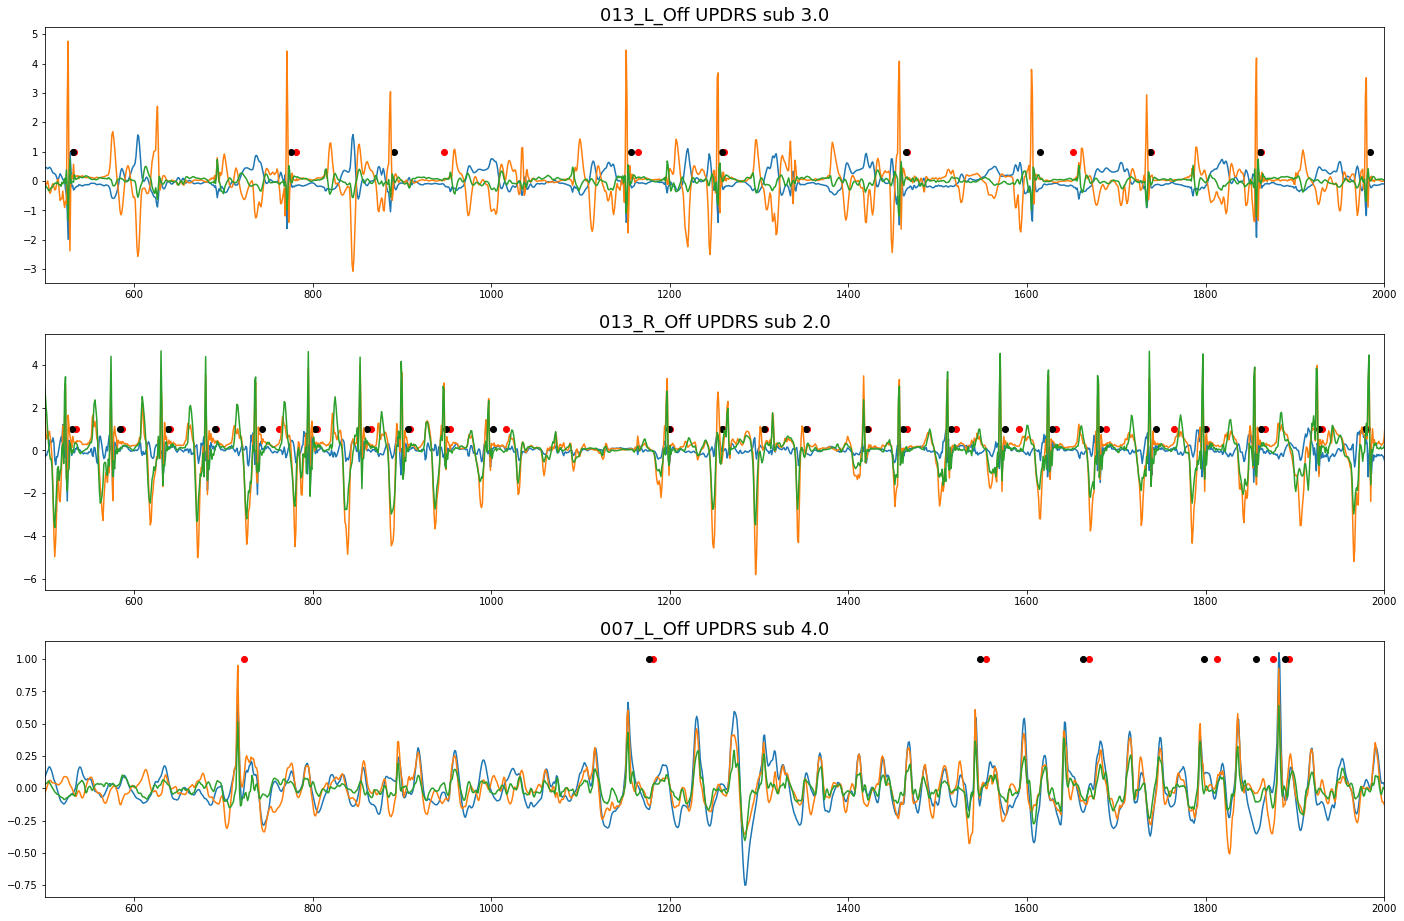

In [1426]:
fig, axes = plt.subplots(3, 1, figsize=(24, 16))

for i, sub in enumerate([
    '013_L_Off',
    '013_R_Off',
    '007_L_Off'
]):

    print(sub)

    tempacc = block_acc[sub][-8]
    temptap, _, _ = tap_run.run_updrs_tapping(
        acc_arr=tempacc, fs=250, already_preprocd=True,
    )

    axes[i].plot(tempacc.T)
    axes[i].scatter(
        [t[0] for t in temptap],
        [1] * len(temptap),
        color='r',
    )
    axes[i].scatter(
        [t[-1] for t in temptap],
        [1] * len(temptap),
        color='k',
    )
    axes[i].set_xlim(500, 2000)

    slopeChanges = smallSlopeChanges(tempacc)
    tempscore = getattr(FEATS[f'{sub}_S1_b2'], 'updrsSubScore')
    axes[i].set_title(
        f'{sub} UPDRS sub {tempscore}',
        fontsize=18,
    )
    
    print(f'Small slope changes {sub}: {slopeChanges}\n'
            f'\t slopeChanges * nTaps = {slopeChanges * len(temptap)}')

plt.show()

(500.0, 1000.0)

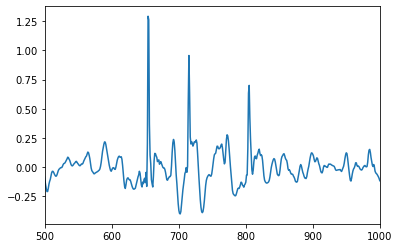

In [1396]:
plt.plot(tempacc[1])
plt.xlim(500, 1000)

In [1450]:
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)


FEATS = {}
fs=250
for run in block_acc.keys():
    print(f'start {run}')

    for S, stim in enumerate(['Off', 'On']):

        for b, block in enumerate([1, 2, 3]):

            tapscore = subscores[run][f'stim{stim}'][b]
            block_n = sel_blocks[run][f'stim{stim}'][b]
            tap_acc = block_acc[run][block_n]

            tap_i, imp_i, acc_temp = tap_run.run_updrs_tapping(
                acc_arr=tap_acc, fs=fs, already_preprocd=True,
            )
            
            if len(tap_i) < 1:
                print(f'No taps detected for {run}_Stim{S}_block {block}')
                continue

            FEATS[f'{run}_S{S}_b{block}'] = tap_ft_extr.tapFeatures(
                triax_arr=acc_temp,
                fs=fs,
                impacts=imp_i,
                tapDict=tap_i,  # result of continTap
                updrsSubScore=tapscore,
            )         

            



start 007_L_Off
No taps detected for 007_L_Off_Stim1_block 1
start 007_L_On
start 007_R_Off
No taps detected for 007_R_Off_Stim1_block 2
No taps detected for 007_R_Off_Stim1_block 3
start 007_R_On
start 014_L_Off
start 014_L_On
start 014_R_Off
start 014_R_On
start 015_L_Off
start 015_L_On
start 015_R_Off
start 015_R_On
start 013_L_Off
start 013_L_On
start 013_R_Off
start 013_R_On


### 1c. Visualise Features

In [1451]:

importlib.reload(fts_boxplot)


ftAx = 'svm'
fts_include = [
    'freq',
    'nTaps',
    'dirChange_run',
    'dirChange_taps',
    f'runRMS_{ftAx}',
    f'tapRMS_{ftAx}',
    f'impactRMS_{ftAx}',
    f'upVelo_{ftAx}',
]
merge_meth = 'mean'
# for merge_meth in ['mean', 'sum', 'stddev', 'trend_slope']:
tempScoreDict = fts_boxplot.combineFeatsPerScore(
    ftDict=FEATS, fts_include=fts_include,
    merge_method=merge_meth,
)
fts_boxplot.plot_boxplot_feats_per_subscore(
    fts_include=fts_include,
    featDict=tempScoreDict,
    merge_method=merge_meth,
    plot_title='Stim-Ramp 3x10sec Tapping',
    figsave_name=f'TEST7_stimRamp_3x10_4pts_{ftAx}Fts_{merge_meth}',
    figsave_dir=fig_dir,
    show=False,
)


## 2. Johannes ACC Data - Individual 30 second-runs, only tapping

In [649]:
importlib.reload(tap_run)
importlib.reload(tap_times)
importlib.reload(tap_ft_extr)
importlib.reload(tap_fts_set)
importlib.reload(tap_import)
importlib.reload(tap_impact)
importlib.reload(tap_preproc)

# define directory and filename
jb_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/data/JB_30s'
jb_fig_dir = '/Users/jeroenhabets/Research/CHARITE/projects/tapping/figures/JB_30s'

mat_dat_f = 'tapsMat.mat'
# mat_ax_ids_f = 'channels.mat'
# mat_run_ids_f = 'subSession.mat'

# Import acc-traces
mat = tap_import.matlab_import(os.path.join(
    jb_dir, mat_dat_f))
fname = mat.filename.split(sep='/')[-1]
mat = mat[fname[:-4]]

# Import subscores
scores218 = np.genfromtxt(
    os.path.join(jb_dir, 'updrs_218.txt'),
    delimiter=',', dtype=str,
)
df_scores218 = pd.DataFrame(data=scores218[1:, :], columns=scores218[0, :])
arr_scores218 = scores218[1:, 2:]
scores545 = arr_scores218[-28:,:]

fs=250

acc545 = mat[:, :, -28:]
fts545 = {}

### check tap detection
tap545 = {}
imp545 = {}
accproc545 = {}

updrs_times = {'t1': (2 * fs, 12 * fs), 't2': (20 * fs, 30 * fs)}

for run_id in np.arange(acc545.shape[2]):
    
    raw_triax = acc545[:, :, run_id].T

    for t_i, t in enumerate(updrs_times.keys()):

        print(f'\nStart run_id {run_id}, timepoint {t_i}')

        sig = raw_triax[
            :, updrs_times[t][0]:updrs_times[t][1]
        ]
        subscore = scores545[run_id, t_i]

        tap_inds, imp_inds, proc_triax = tap_run.run_updrs_tapping(
            acc_arr=sig, fs=fs, already_preprocd=False, #orig_fs=4000,
        )
        ## check tap detect
        tap545[f'run{run_id}_t{t_i}'] = tap_inds
        imp545[f'run{run_id}_t{t_i}'] = imp_inds
        accproc545[f'run{run_id}_t{t_i}'] = proc_triax

        fts545[f'run{run_id}_t{t_i}'] = tap_ft_extr.tapFeatures(
            triax_arr=proc_triax,
            fs=fs,
            impacts=imp_inds,
            tapDict=tap_inds,  # result of continTap
            updrsSubScore=subscore,
        )




Start run_id 0, timepoint 0

Start run_id 0, timepoint 1

Start run_id 1, timepoint 0

Start run_id 1, timepoint 1

Start run_id 2, timepoint 0

Start run_id 2, timepoint 1

Start run_id 3, timepoint 0

Start run_id 3, timepoint 1

Start run_id 4, timepoint 0

Start run_id 4, timepoint 1

Start run_id 5, timepoint 0

Start run_id 5, timepoint 1

Start run_id 6, timepoint 0

Start run_id 6, timepoint 1

Start run_id 7, timepoint 0

Start run_id 7, timepoint 1

Start run_id 8, timepoint 0

Start run_id 8, timepoint 1

Start run_id 9, timepoint 0

Start run_id 9, timepoint 1

Start run_id 10, timepoint 0

Start run_id 10, timepoint 1

Start run_id 11, timepoint 0

Start run_id 11, timepoint 1

Start run_id 12, timepoint 0

Start run_id 12, timepoint 1

Start run_id 13, timepoint 0

Start run_id 13, timepoint 1

Start run_id 14, timepoint 0

Start run_id 14, timepoint 1

Start run_id 15, timepoint 0

Start run_id 15, timepoint 1
Pos/Neg switched

Start run_id 16, timepoint 0

Start run_id

In [778]:
fts_include = [
    'freq',
    'runRMS_svm',
    'tapRMS_svm',
    'impactRMS_svm',
    'upVelo_svm',
]
merge_meth = 'trend_slope'

tempScoreDict = fts_boxplot.combineFeatsPerScore(
    ftDict=fts545, fts_include=fts_include,
    merge_method=merge_meth,
)
fts_boxplot.plot_boxplot_feats_per_subscore(
    fts_include=fts_include,
    featDict=tempScoreDict,
    merge_method=merge_meth,
    plot_title='545 28 aDBS traces',
    figsave_name='',  # f'sub545_aDBS_box5fts_{merge_meth}',
    figsave_dir=jb_fig_dir,
    show=False,
)


# 3. Clustering & Classifying

- Candidate vetors based on descriptives and concept
    - nTaps
    - freq
    - upVelo sum [std-dev + coefVar]
    - impact RMS [coefVar + stddev]
    - tapRMS and impactRMS [sum]
    - 
- include per run (array tap-features): sum, mean, stddev, trend_slope

- Cluster on UPDRS 4?

### 3a. ML-Vector Preparation

In [1063]:
import lfpecog_features.tapping_feat_calc as ft_calc

In [1454]:
importlib.reload(ft_calc)

ft_axis = 'svm'
single_ft_names = ['nTaps', 'freq',]
arr_ft_names = [
    f'tapRMS_{ft_axis}',
    f'upVelo_{ft_axis}',
    f'impactRMS_{ft_axis}',
    'dirChange_taps',
]
ft_aggr_to_add = [
    'mean', 'stddev', 'sum', 'trend_slope'
]

n_samples = len(FEATS.keys())

Xdf = pd.DataFrame(
    data=np.zeros((
        n_samples,
        len(single_ft_names) + (len(arr_ft_names) * 4)
    )), columns=[single_ft_names + [
        f'{f}_{m}' for f in arr_ft_names for m in ft_aggr_to_add
    ]]
)
y = ft_calc.nan_array([Xdf.shape[0], 1])
for s in range(Xdf.shape[0]):
    y[s] = getattr(
        FEATS[list(FEATS.keys())[s]],
        'updrsSubScore'
    )

for ft in single_ft_names:
    for s, sam in enumerate(FEATS.keys()):
        ft_value = getattr(FEATS[sam], ft)
        Xdf.iloc[s][ft] = ft_value


max_nTaps = np.max([FEATS[k].nTaps for k in FEATS.keys()])

arr_feats = ft_calc.nan_array([
    len(arr_ft_names),
    max_nTaps,
    n_samples
])

for f, ft in enumerate(arr_ft_names):

    for s, sam in enumerate(FEATS.keys()):

        ft_values = getattr(FEATS[sam], ft)
        arr_feats[f, :len(ft_values), s] = ft_values

# Normalise vector per array-feature over all samples
for ft_row in range(len(arr_ft_names)):

    vec_max = np.nanmax(arr_feats[ft_row, :, :])
    arr_feats[ft_row, :, :] = arr_feats[ft_row, :, :] / vec_max

# Normalise single feature over all samples
for ft in single_ft_names:

    fmax = np.max(Xdf[ft])
    Xdf[ft] = Xdf[ft] / fmax

# Aggregate array features
for ft, ft_name in enumerate(arr_ft_names):

    for m in ft_aggr_to_add:

        for s in np.arange(X.shape[0]):
            
            value = ft_calc.aggregate_arr_fts(
                method=m, arr=arr_feats[ft, :, s]
            )
            
            Xdf.iloc[s][f'{ft_name}_{m}'] = value

### assert np.sum(np.isnan(Xdf.values)) == 0
X = Xdf.values

/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


### 3b. Clustering

In [1231]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# DBSCAN
# Laio

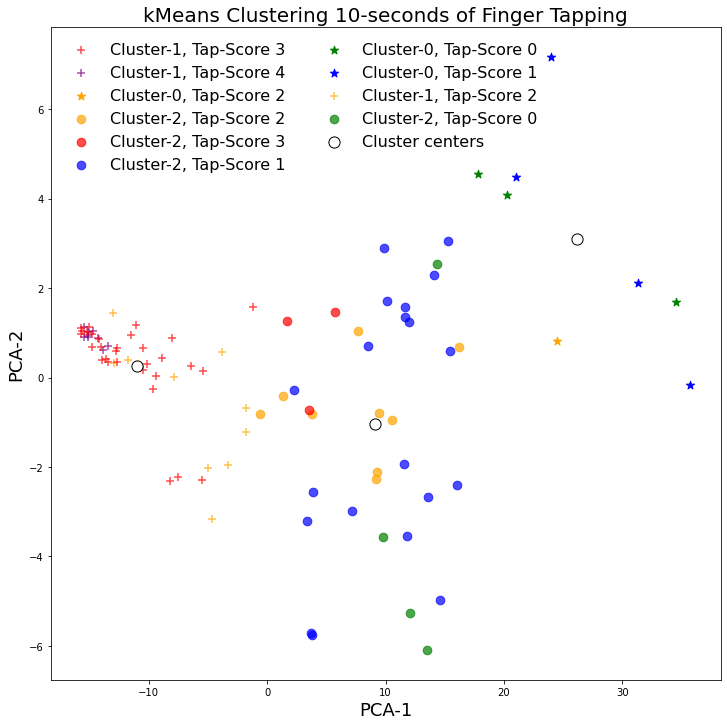

In [1455]:
### Cluster Settings
n_clusters = 3


X = Xdf.values
pca = PCA(2)
X = pca.fit_transform(X)

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=27
)
y_clust_labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

y_cluster0 = y[y_clust_labels == 0]
y_cluster1 = y[y_clust_labels == 1]

score_cols = {
    0: 'green',
    1: 'blue',
    2: 'orange',
    3: 'red',
    4: 'purple'
}

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
s = 75
for n, X_pca_row in enumerate(X):

    score = int(y[n])
    col = score_cols[score]

    if y_clust_labels[n] == 0:
        ax.scatter(
            X[n, 0], X[n, 1],
            label=f'Cluster-0, Tap-Score {score}',
            # edgecolor=col, facecolor='w',
            s=s, color=col, marker='*',
        )
    
    elif y_clust_labels[n] == 1:
        ax.scatter(
            X[n, 0], X[n, 1], marker='+',
            label=f'Cluster-1, Tap-Score {score}',
            color=col, s=s, alpha=.7,
        )

    elif y_clust_labels[n] == 2:
        ax.scatter(
            X[n, 0], X[n, 1],
            label=f'Cluster-2, Tap-Score {score}',
            color=col, s=s, alpha=.7,
        )

for c in range(centroids.shape[0]):
    ax.scatter(
        centroids[c, 0], centroids[c, 1],
        edgecolor='k', s=s + 50, fc='w',
        label='Cluster centers'
    )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(),
    frameon=False, fontsize=16,
    ncol=2,
    # loc='lower center',
)

ax.set_xlabel('PCA-1', fontsize=18)
ax.set_ylabel('PCA-2', fontsize=18)
ax.set_title(
    'kMeans Clustering 10-seconds of Finger Tapping',
    fontsize=20
)

# plt.savefig(
#     os.path.join(
#         fig_dir,
#         f'kMeans_{n_clusters}clusts_n93'),
#     dpi=150, facecolor='w',
# )

plt.show()

# plt.hist(labels0, color='purple')
# plt.hist(labels1, color='green')

### 3c. Classification

In [1367]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

#### Classifying UPDRS 0 - 1 - 2 - 3 - 4

In [1369]:
# CLassification Settings
nFolds = 4

# Shuffle order
X = Xdf.values

allData = np.hstack((X, y))
X_shf = allData[:, :14]
y_shf = allData[:, 14]
np.random.seed(27)
np.random.shuffle(allData)

skf = StratifiedKFold(n_splits=nFolds,)
skf.get_n_splits(X_shf, y_shf)

y_pred, y_true = {}, {}

for F, (train_index, test_index) in enumerate(
    skf.split(X, y)
):
    print(f'Linear Support Vector, fold #{F}')

    X_train, X_test = X_shf[train_index], X_shf[test_index]
    y_train, y_test = y_shf[train_index], y_shf[test_index]

    clf = LinearSVC(penalty='l2', C=1.0,)
    clf.fit(X=X_train, y=y_train)
    print(clf.score(X=X_test, y=y_test))
    # for own scoring
    y_pred[F] = clf.predict(X=X_test)
    y_true[F] = y_test
    # print(multilabel_confusion_matrix(y_true[F], y_pred[F]))

    



Linear Support Vector, fold #0
0.4583333333333333
Linear Support Vector, fold #1
0.4782608695652174
Linear Support Vector, fold #2
0.43478260869565216
Linear Support Vector, fold #3
0.5217391304347826


/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Boolean Classifying (UPDRS 0 or 4 vs The Rest)

In [1377]:
# CLassification Settings
nFolds = 4
score_to_predict = 0

# Shuffle order
X = Xdf.values
y_bool = y == score_to_predict

allData = np.hstack((X, y_bool))

np.random.seed(27)
np.random.shuffle(allData)

X_shf = allData[:, :14]
y_shf = allData[:, 14]

skf = StratifiedKFold(n_splits=nFolds,)
skf.get_n_splits(X_shf, y_shf)

y_pred, y_true = {}, {}
print(
    'Classification of UPDRS subscore '
    f'{score_to_predict} versus thre rest')
for F, (train_index, test_index) in enumerate(
    skf.split(X, y)
):
    print(f'\nLinear Support Vector, fold #{F}')

    X_train, X_test = X_shf[train_index], X_shf[test_index]
    y_train, y_test = y_shf[train_index], y_shf[test_index]

    clf = LinearSVC(penalty='l2', C=1.0,)
    clf.fit(X=X_train, y=y_train)
    print(f'Accuracy: {clf.score(X=X_test, y=y_test)}')
    # for own scoring
    y_pred[F] = clf.predict(X=X_test)
    y_true[F] = y_test
    print(classification_report(y_true[F], y_pred[F]))
    



Classification of UPDRS subscore 0 versus thre rest

Linear Support Vector, fold #0
Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        23
         1.0       0.00      0.00      0.00         1

    accuracy                           0.96        24
   macro avg       0.48      0.50      0.49        24
weighted avg       0.92      0.96      0.94        24


Linear Support Vector, fold #1
Accuracy: 0.8695652173913043
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93        21
         1.0       0.00      0.00      0.00         2

    accuracy                           0.87        23
   macro avg       0.45      0.48      0.47        23
weighted avg       0.83      0.87      0.85        23


Linear Support Vector, fold #2
Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        21
  

/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/sklearn/metrics/_classification.py: